In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import time
from urllib.parse import urljoin
import numpy as np

In [2]:
base_site="https://www.naukri.com"
all_page_links=[]
no_of_pages=30
for i in range(no_of_pages):
    if i >0:
        all_page_links.append(urljoin(base_site,("/machine-learning-jobs-in-india-{}".format(i))))

job_pages=[]
driver = webdriver.Firefox()
for link in all_page_links:
    driver.get(link)
    time.sleep(10)
    job_pages.append(BeautifulSoup(driver.page_source, 'lxml'))
driver.quit()

In [3]:
jobs=[]
for page in range(no_of_pages-1):
    jobs.append(job_pages[page].find_all("div",attrs={"class":"srp-jobtuple-wrapper"}))

jobs_data = []

for job_page in jobs:
    for job_html in job_page:
        job_soup = BeautifulSoup(str(job_html), 'html.parser')

        title = job_soup.find('a', class_='title').text.strip()
        location_element = job_soup.find('span', class_='locWdth')
        location = location_element.text.strip() if location_element else 'NA'
        
        experience_element = job_soup.find('span', class_='expwdth')
        experience = experience_element.text.strip() if experience_element else 'NA'

        key_skills = [skill.text.strip() for skill in job_soup.find_all('li', class_='tag-li')]

        jobs_data.append([title, location, experience, key_skills])

columns = ['Title', 'Location','Experience', 'Key Skills']
df = pd.DataFrame(jobs_data, columns=columns) 
df.head()

,Title,Location,Experience,Key Skills
0,Xoriant is hiring Datascience Engineer_Immedia...,"Hybrid - Pune, Maharashtra, Bangalore Rural, K...",2-5 Yrs,"[Machine Learning Algorithms, prompt engineeri..."
1,Machine Learning Engineer / AI Engineer / Data...,Noida,2-4 Yrs,"[NoSQL, Linux, Postgresql, Artificial Intellig..."
2,Machine Learning Operations AI Platform Engineer,Bangalore/Bengaluru,4-6 Yrs,"[AWS Lambda, Sagemaker, AWS, deep learning, al..."
3,Machine Learning Operations AI Platform Engineer,Bangalore/Bengaluru,8-10 Yrs,"[AWS Lambda, Sagemaker, AWS, deep learning, ne..."
4,Machine Learning AI Platform Engineer,Bangalore/Bengaluru,6-8 Yrs,"[SQL, MySQL, Machine learning, Oracle, Python,..."


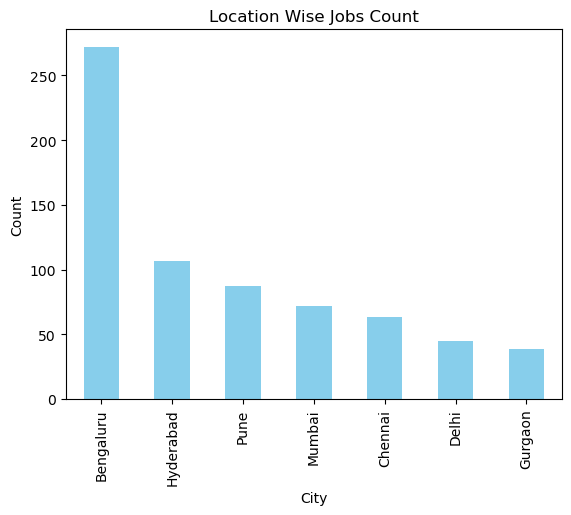

In [4]:
#Location Wise Jobs Count

import matplotlib.pyplot as plt

locations_df = df['Location'].str.split(', ', expand=True)
locations_df = locations_df.apply(lambda x: x.str.replace(' ', '').str.replace('Hybrid-', '') if x.dtype == "O" else x)

location_mapping = {'Bangalore/Bengaluru': 'Bengaluru',
                'Hyderabad/Secunderabad': 'Hyderabad',
                'Delhi/NCR': 'NewDelhi',
                'NewDelhi': 'Delhi',
                'Mumbai(AllAreas)': 'Mumbai',
                'Gurgaon/Gurugram': 'Gurgaon'
}
for col in locations_df.columns:
    locations_df[col] = locations_df[col].map(location_mapping).fillna(locations_df[col])

locations_series = locations_df.stack()
location_counts = locations_series.value_counts()

# Plotting the bar chart
location_counts.head(7).plot(kind='bar', color='skyblue')
plt.title('Location Wise Jobs Count')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()

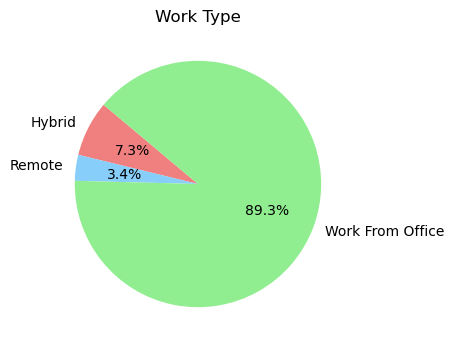

In [5]:
# work type (remote,hybrid,office)

count_hybrid = df['Location'].str.contains('Hybrid', case=False).sum()
count_remote=df['Location'].str.contains('Remote', case=False).sum()
count_office = len(df[~df['Location'].str.contains('Hybrid|Remote', case=False)])


labels = ['Hybrid', 'Remote', 'Work From Office']
sizes = [count_hybrid, count_remote, count_office]
colors = ['lightcoral', 'lightskyblue', 'lightgreen']

# Plotting the pie chart
fig, ax = plt.subplots(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Work Type')
plt.show()


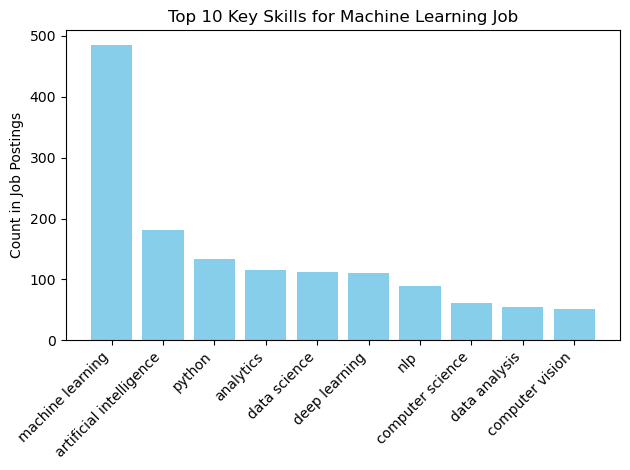

In [6]:
# Top 10 Skills Machine Learning Job

keyskills_lowercase = df['Key Skills'].apply(lambda x: [item.lower() for item in x])
keyskills_counts = keyskills_lowercase.explode()
keyskills_counts = keyskills_counts[~keyskills_counts.isin(["machine","data","science","coding"])]

values_to_replace = {'natural language processing': 'nlp','analytical': 'analytics'}
keyskills_counts = keyskills_counts.replace(values_to_replace)

keyskills_count = keyskills_counts.value_counts()
top_skills = keyskills_count.head(10)

# Plotting the bar chart
plt.bar(top_skills.index, top_skills.values, color='skyblue')
plt.xlabel('')
plt.ylabel('Count in Job Postings')
plt.title('Top 10 Key Skills for Machine Learning Job')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

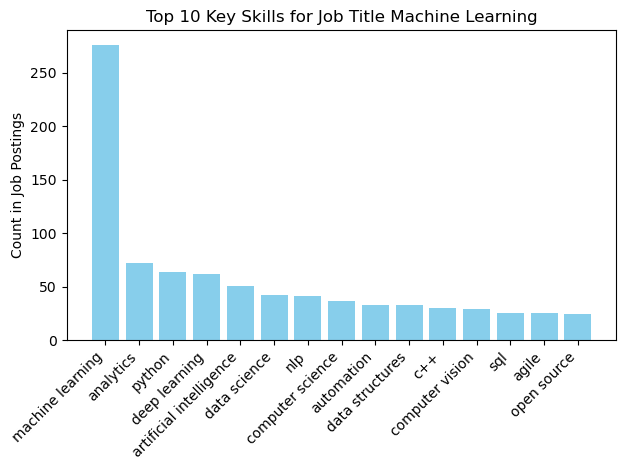

In [7]:
# Top Skills for Job Title Machine Learning Engineer
title_counts = df['Title'].value_counts()
title_machine_learning= df[df['Title'].str.contains('Machine Learning', case=False)]

keyskills_machine_learning = title_machine_learning['Key Skills']
keyskills_lowercase = keyskills_machine_learning.apply(lambda x: [item.lower() for item in x])
keyskills_flat_lower = keyskills_lowercase.explode()
keyskills_flat_lower = keyskills_flat_lower[~keyskills_flat_lower.isin(["machine","coding"])]
values_to_replace = {'natural language processing': 'nlp','analytical': 'analytics'}
keyskills_flat_lower = keyskills_flat_lower.replace(values_to_replace)

keyskills_count = keyskills_flat_lower.value_counts()
top_10_skills = keyskills_count.head(15)

# Plotting the bar chart
plt.bar(top_10_skills.index, top_10_skills.values, color='skyblue')
plt.xlabel('')
plt.ylabel('Count in Job Postings')
plt.title('Top 10 Key Skills for Job Title Machine Learning')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

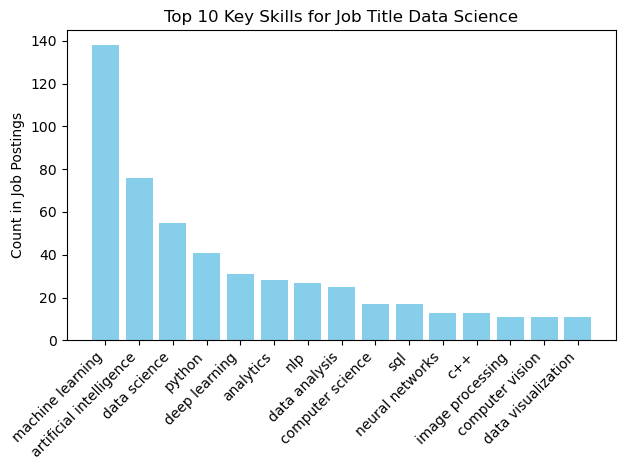

In [8]:
# Top Skills for Job Title Data Scientist

title_data_scientist= df[df['Title'].str.contains('Data Scientist', case=False)]
keyskills_data_scientist = title_data_scientist['Key Skills']
keyskills_lowercase = keyskills_data_scientist.apply(lambda x: [item.lower() for item in x])
keyskills_flat_lower = keyskills_lowercase.explode()
keyskills_flat_lower = keyskills_flat_lower[~keyskills_flat_lower.isin(["machine","data","science","coding"])]

values_to_replace = {'natural language processing': 'nlp','analytical': 'analytics'}
keyskills_flat_lower = keyskills_flat_lower.replace(values_to_replace)

keyskills_count = keyskills_flat_lower.value_counts()
top_10_skills = keyskills_count.head(15)

# Plotting the bar chart
plt.bar(top_10_skills.index, top_10_skills.values, color='skyblue')
plt.xlabel('')
plt.ylabel('Count in Job Postings')
plt.title('Top 10 Key Skills for Job Title Data Science')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

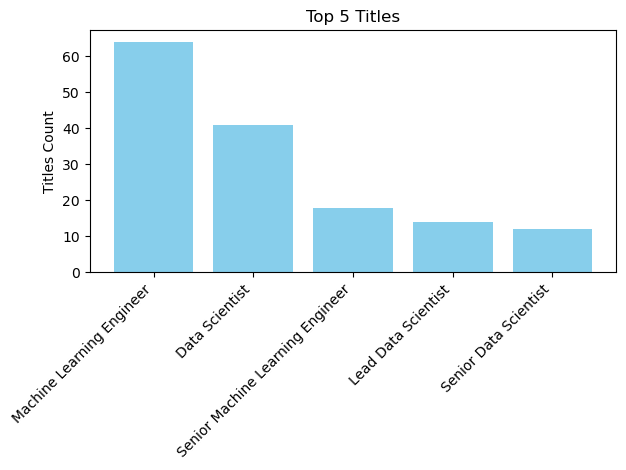

In [9]:
# Top Job Titles

all_titles=df['Title']
titles_count=all_titles.value_counts()
top_titles=titles_count.head(5)
plt.bar(top_titles.index, top_titles.values, color='skyblue')
plt.xlabel('')
plt.ylabel('Titles Count')
plt.title('Top 5 Titles')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

In [15]:
# Position wise Number of Job Openings
experience_df = df["Experience"]
experience_df = experience_df.dropna().astype(int)

bins = [0, 3, 6, 11, 17, 24]
labels = ['Entry Level', 'Associate', 'Senior', 'Manager', 'Senior Manager']
experience_bins = pd.cut(experience_df, bins=bins, labels=labels, include_lowest=True)
experience_counts = experience_bins.value_counts(sort=False)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
experience_counts.plot(kind='line', marker='o', linestyle='-', color='b', ax=ax1)

# Bar chart
for label, count in zip(experience_counts.index, experience_counts.values):
    ax1.bar(label, count, color='lightcoral', alpha=0.7, align='center', label=f"{label}: {count}")

ax1.set_xlabel('Experience Level')
ax1.set_ylabel('Number Of Openings')
ax1.set_title('Number of Openings for each Experience Level')
ax1.legend()

# Pie chart
experience_percentage = (experience_counts / experience_counts.sum()) * 100
ax2.pie(experience_percentage, labels=experience_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink'])
ax2.set_title('Percentage of Jobs by Experience Level')

plt.show()

ValueError: invalid literal for int() with base 10: '2-5 Yrs'

In [ ]:
# Experience wise Number of Openings

experience_df =  df['Experience'].str.replace(' Yrs', '')
pd.set_option('display.max_rows', None)

experience_df  = experience_df.apply(lambda exp: 
    list(range(int(exp.split('-')[0]), int(exp.split('-')[-1]) + 1)) 
    if '-' in exp and all(part.isdigit() for part in exp.split('-')) 
    else [int(exp)] if exp.isdigit() 
    else np.nan
)
experience_df = experience_df.explode()
experience_count = experience_df.value_counts()

experience_count = experience_count.sort_index()

# Plot a line chart
fig, ax = plt.subplots(figsize=(10, 4))
experience_count.plot(kind='line', marker='o', linestyle='-', color='b')
plt.xticks(range(len(experience_count.index)), experience_count.index)
plt.xlabel('Experience Level')
plt.ylabel('Number of Jobs')
plt.title('Experience wise Number of Openings')
plt.show()

In [18]:
df.head(15)

,Title,Location,Experience,Key Skills
0,Xoriant is hiring Datascience Engineer_Immedia...,"Hybrid - Pune, Maharashtra, Bangalore Rural, K...",2-5 Yrs,"[Machine Learning Algorithms, prompt engineeri..."
1,Machine Learning Engineer / AI Engineer / Data...,Noida,2-4 Yrs,"[NoSQL, Linux, Postgresql, Artificial Intellig..."
2,Machine Learning Operations AI Platform Engineer,Bangalore/Bengaluru,4-6 Yrs,"[AWS Lambda, Sagemaker, AWS, deep learning, al..."
3,Machine Learning Operations AI Platform Engineer,Bangalore/Bengaluru,8-10 Yrs,"[AWS Lambda, Sagemaker, AWS, deep learning, ne..."
4,Machine Learning AI Platform Engineer,Bangalore/Bengaluru,6-8 Yrs,"[SQL, MySQL, Machine learning, Oracle, Python,..."
5,Artificial Intelligence and Machine Learning (...,"Hyderabad/Secunderabad, Bangalore/Bengaluru, M...",5-10 Yrs,"[Artificial Intelligence, Big Data, Data Visua..."
6,Software Developer - Machine Learning,Hybrid - Bengaluru,0-2 Yrs,"[Software Development, PHP, Machine Learning, ..."
7,Principal Data Scientist | Machine Learning | NLP,"Indore, Bangalore/Bengaluru",5-10 Yrs,"[NLP, Machine Learning, panda, Rnn, Explanable..."
8,Lead Cloud Data Engineer / Artificial Intellig...,Bangalore/Bengaluru,5-7 Yrs,"[Artificial Intelligence, Pyspark, Data Engine..."
9,Machine Learning Engineer,"Kolkata, Mumbai, New Delhi, Hyderabad/Secunder...",5-7 Yrs,"[Data analysis, orchestration, GCP, Artificial..."
